In [1]:
import xarray as xr
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
import time

base_dir = '/glade/work/kjmayer/research/catalyst/S2S_ocn_lnd_atm/'

from data_prep.data_loader import GetXData, GetYData,lead_shift
import utils.utils
from utils.utils import get_config
from model.metrics import weighted_l1_loss_tf

config = get_config("exp_1")
GLOBAL_SEED = 2147483648
tf.random.set_seed(GLOBAL_SEED)
np.random.seed(config["seed"])
random.seed(config["seed"])


def minmax_normalize(data,dim):
    min = data.min(dim)
    max = data.max(dim)
    return((data - min)/(max - min))

2024-12-18 12:13:12.984641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 12:13:13.715764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
Memory growth enabled for GPUs


In [2]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
def scheduler(epoch, lr):
    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    if epoch < 20:
        return lr
    else:
        return lr * tf.constant(.9,dtype=tf.float32)
    

# ---------- Two Sequential Convolution Up & Down ----------
def nconv(x, n_filters = 16, n_conv = 2, kernel_size = (3,3), stride = (1,1), padding = 'same', act_func = 'relu',lasso_penalty = 0.0,ridge_penalty = 0.0):
    
    for n in range(n_conv):
        x = layers.Conv2D(filters = n_filters,
                          kernel_size = kernel_size,
                          strides = stride,
                          padding = padding,
                          activation = act_func,
                          use_bias = True,
                          kernel_regularizer = tf.keras.regularizers.l1_l2(l1=lasso_penalty, l2=ridge_penalty),
                          kernel_initializer = tf.keras.initializers.RandomNormal(seed = 1000), 
                          bias_initializer = tf.keras.initializers.RandomNormal(seed = 1000),
                         )(x)

        x = layers.BatchNormalization()(x)
    
    skip = x
    
    return x,skip

# for upsampling using convolutions
def convT(x, n_filters = 16, kernel_size = (2,2), stride = (2,2), padding = 'valid', act_func = 'relu'): # double image size
    x = layers.Conv2DTranspose(filters = n_filters,
                               kernel_size = kernel_size,
                               strides = stride,
                               padding = padding,
                               activation = act_func,
                               use_bias = True,
                               kernel_initializer = tf.keras.initializers.RandomNormal(seed = 1000),
                               bias_initializer = tf.keras.initializers.RandomNormal(seed = 1000),
                              )(x)
    
    x = layers.BatchNormalization()(x)
    
    return x

# ---------- Maxpooling & upsampling ----------
def maxpool(x, pool_size = (2,2), stride = (2,2), padding = 'valid'): # halve image size
    
    x = layers.MaxPool2D(pool_size = pool_size,
                         strides = stride,
                         padding = padding
                        )(x)
    
    return x

# for upsampling using interpolation 
def upsample(x, skip, pool_size = (2,2), stride = (2,2), padding = 'valid'):
    
    x = layers.Upsampling2D(pool_size = pool_size,
                            strides = stride,
                            padding = padding
                           )(x)
    
    x = layers.Concatenate()([x,skip])
    
    return x

In [3]:
def create_unet(input_shape, n_filters_list, n_ouput):
    tf.keras.backend.clear_session() 
    skip = [] #empty list to save skip connections

    # ----- input of unet -----
    unet_input = keras.Input(shape = input_shape)
    x = unet_input
    
    # ----- first encoder layer -----
    x, skip_temp = nconv(x = x, n_filters = n_filters_list[0], n_conv = 2, ridge_penalty = 0)
    skip.append(skip_temp)
    
    # ----- encoder -----
    for i in np.arange(1,len(n_filters_list)):
        
        if i < (len(n_filters_list)-1):
            # ----- internal layers -----
            x = maxpool(x, pool_size = (2,2), stride = (2,2), padding = 'valid')
            x, skip_temp = nconv(x = x, n_filters = n_filters_list[i], n_conv = 2)
            skip.append(skip_temp)
        
        else:
            # ----- base of unet -----
            x = maxpool(x, pool_size = (2,2), stride = (2,2), padding = 'valid')
            x,_ = nconv(x = x, n_filters = n_filters_list[i], n_conv = 2)
            
    
    # ----- decoder -----
    for i in np.arange(0,len(n_filters_list[:-1]))[::-1]:
        x   = convT(x = x, n_filters = n_filters_list[i], kernel_size = (2,2), stride = (2,2), padding = 'valid')
        x   = layers.Concatenate()([x,skip[i]])
        x,_ = nconv(x = x, n_filters = n_filters_list[i], n_conv = 2)

    # ----- output of unet -----
    unet_output,_ = nconv(x = x, n_filters = n_ouput, n_conv = 1, act_func = 'linear')

    # ----- create unet -----
    unet = keras.Model(unet_input, unet_output, name = 'unet')
    
    return unet

In [21]:
LEAD = config["data_loader"]["lead"][0] # will loop over this for training eventually
trainfinames = config["data_loader"]["anommems_finames"][0:8]
valfinames = config["data_loader"]["anommems_finames"][8:9]
# xtrain, xtrainmean, xtrainstd, xtrainmin, xtrainmax
xtrain, xtrainmin, xtrainmax = GetXData(dir=config["data_loader"]["base_dir"],
                                      var=config["data_loader"]["atm_var"],
                                      finames=trainfinames,
                                      train=True,
                                      climo=False)[0]
# xtrain = xtrain.stack(l=('lat','lon'))
xtrain_shift = lead_shift(xtrain, lead=LEAD, forward=False)
xtrain_shift = xtrain_shift.drop(['mem','time'])

#ytrain, ytrainmean, ytrainstd, ytrainmax, ytrainmin
ytrain, ytrainmax, ytrainmin = GetYData(dir=config["data_loader"]["base_dir"],
                                       var=config["data_loader"]["atm_var"],
                                       finames=trainfinames,
                                       train=True,
                                       norm=True,
                                       )[0]

# ytrain = ytrain.sel(lat=slice(29,61))
# ytrain = ytrain.stack(l=('lat','lon'))
ytrain_shift = lead_shift(ytrain, lead=LEAD, forward=True)

xval = GetXData(dir=config["data_loader"]["base_dir"],
                var=config["data_loader"]["atm_var"],
                finames=valfinames,
                train=False,
                # trainmean=xtrainmean,
                # trainstd=xtrainstd,
                trainmin=xtrainmin,
                trainmax=xtrainmax,
                climo=False)[0]
# 
xval_shift = lead_shift(xval, lead=LEAD, forward=False)
#xval_shift = xval_shift.drop(['mem',time'])
xval_shift = xval_shift.drop(['time'])

yval = GetYData(dir=config["data_loader"]["base_dir"],
                var=config["data_loader"]["atm_var"],
                finames=valfinames,
                train=False,
                # trainmean=ytrainmean,
                # trainstd=ytrainstd,
                norm=True,
                trainmax=ytrainmax,
                trainmin=ytrainmin,
                )[0]

# yval = yval.sel(lat=slice(29,61))
# yval = yval.stack(l=('lat','lon'))
yval_shift = lead_shift(yval, lead=LEAD, forward=True)


# climo (same for train, val, and test --> basically a DOY encoder)
xclimo, climomin, climomax = GetXData(dir = config["data_loader"]["base_dir"],
                                     var = config["data_loader"]["atm_var"],
                                     finames = config["data_loader"]["climo_finame"],
                                     train = False, # MUST ALWAYS BE False FOR CLIMO
                                     climo = True)[0]
# climo appended to same length as training
# xclimo = xclimo.rename({'dayofyear': 'time'})
xclimo_train = xr.concat([xclimo]*int(xtrain.shape[0]/365),dim='mem')
xclimo_train = xclimo_train.stack(s=('mem','dayofyear')).transpose('s', 'lat', 'lon').reset_index(['s'])
xclimo_train = xclimo_train.drop(['mem','dayofyear'])
xclimo_train_shift = lead_shift(xclimo_train,lead=LEAD,forward=False)

# climo appended to same length as validation
xclimo_val = xr.concat([xclimo]*int(xval.shape[0]/365),dim='mem')
# xclimo_val = xclimo_val.stack(s=('mem','dayofyear')).transpose('s', 'lat', 'lon').reset_index(['s'])
xclimo_val = xclimo_val.stack(time=('mem','dayofyear')).transpose('time', 'lat', 'lon').reset_index(['time'])
xclimo_val = xclimo_val.drop(['mem','dayofyear'])
xclimo_val_shift = lead_shift(xclimo_val,lead=LEAD,forward=False)

/glade/work/kjmayer/conda-envs/tf212gpu/lib/python3.10/site-packages/xarray/core/variable.py:1777: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
/glade/work/kjmayer/conda-envs/tf212gpu/lib/python3.10/site-packages/xarray/core/variable.py:1777: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avo

In [22]:
# get lat-lon maps for training
shiftedlon = np.abs(((xtrain_shift.lon - 180) % 360) - 180)
latnorm = minmax_normalize(xtrain_shift.lat,dim='lat')
lonnorm = minmax_normalize(shiftedlon,dim='lon')

# just northern hemisphere: [:,-32:,:]
latnorm_map = latnorm.expand_dims({'lon':len(xtrain_shift.lon)}).T#.values
lonnorm_map = lonnorm.expand_dims({'lat':len(xtrain_shift.lat)})#.values
latnorm_map = latnorm_map.expand_dims(dim={"features": 1},axis=-1)
lonnorm_map = lonnorm_map.expand_dims(dim={"features": 1},axis=-1)

In [23]:
# just northern hemisphere: [:,-32:,:]
firstdim = xtrain_shift.dims[0]
thirddim = xtrain_shift.dims[-2]
forthdim = xtrain_shift.dims[-1]
Xtrain = xr.concat([xtrain_shift, xclimo_train_shift],
                   dim='features').transpose(firstdim,thirddim,forthdim,'features')
# Xtrain = xtrain_shift.expand_dims(dim={"features": 1},axis=-1)
del xtrain_shift, xclimo_train_shift

firstdim = xval_shift.dims[0]
Xval = xr.concat([xval_shift, xclimo_val_shift],
                 dim='features').transpose(firstdim,thirddim,forthdim,'features')
# Xval = xval_shift.expand_dims(dim={"features": 1},axis=-1)
del xval_shift, xclimo_val_shift

Ytrain = ytrain_shift.values
del ytrain_shift

Yval = yval_shift.values
del yval_shift

In [29]:
## Prep training and validation for ANN
config = get_config("exp_1")

Xtrain_wlat = xr.concat([Xtrain, latnorm_map], dim='features')  # Shape (H, W,C+1)
Xtrain_wlatlon = xr.concat([Xtrain_wlat, lonnorm_map], dim='features').values  # Shape (H, W, C+2)

Xval_wlat = xr.concat([Xval, latnorm_map], dim='features') 
Xval_wlatlon = xr.concat([Xval_wlat, lonnorm_map], dim='features').values

In [30]:
Xtrain_wlatlon.shape

(189799, 96, 144, 4)

In [31]:
## create NN architecture
config = get_config("exp_1")
input_shape = Xtrain_wlatlon.shape[1:]
n_filters_list = [8, 16, 32]

unet = create_unet(input_shape = input_shape, n_filters_list = n_filters_list, n_ouput = 1)
unet.summary()

# ------ Training Hyperparameters ------
optimizer = tf.optimizers.SGD(learning_rate = config["optimizer"]["sgd_args"]["lr"],
                              momentum = config["optimizer"]["sgd_args"]["momentum"]) 

# use yval.lat so that the lat dimension is the same as latxlon
# northern hemisphere: [-32:]
# weights = np.cos(np.deg2rad(yval.lat)).values
# weights = weights[:,np.newaxis] 

# ------ Compile Model -----
unet.compile(optimizer = optimizer,
             loss = tf.keras.losses.MeanAbsoluteError())

# ----- Callbacks -----
ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto',
                                      patience = config["lr_scheduler"]["patience"], verbose = 0, restore_best_weights = True)
LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

# ------ Train UNet -----
start_time = time.time()
history = unet.fit(Xtrain_wlatlon, Ytrain,
                   validation_data = (Xval_wlatlon, Yval),
                   epochs = config["trainer"]["max_epochs"],
                   batch_size = config["data_loader"]["batch_size"], 
                   shuffle = True,
                   verbose = 2,
                   callbacks = [ES,LR])
stop_time = time.time()
tf.print(f"\nTRAINING TIME = {(stop_time - start_time)/60.:.2f} minutes\n")

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 144, 8)   296         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 144, 8)  32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

2024-12-18 13:13:05.443635: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


Epoch 1/10
1898/1898 - 120s - loss: 0.0906 - val_loss: 0.0562 - lr: 0.0010 - 120s/epoch - 63ms/step
Epoch 2/10
1898/1898 - 97s - loss: 0.0556 - val_loss: 0.0547 - lr: 0.0010 - 97s/epoch - 51ms/step
Epoch 3/10
1898/1898 - 94s - loss: 0.0541 - val_loss: 0.0536 - lr: 0.0010 - 94s/epoch - 49ms/step
Epoch 4/10
1898/1898 - 100s - loss: 0.0532 - val_loss: 0.0528 - lr: 0.0010 - 100s/epoch - 52ms/step
Epoch 5/10
1898/1898 - 103s - loss: 0.0525 - val_loss: 0.0522 - lr: 0.0010 - 103s/epoch - 54ms/step
Epoch 6/10
1898/1898 - 93s - loss: 0.0519 - val_loss: 0.0516 - lr: 0.0010 - 93s/epoch - 49ms/step
Epoch 7/10
1898/1898 - 94s - loss: 0.0514 - val_loss: 0.0511 - lr: 0.0010 - 94s/epoch - 49ms/step
Epoch 8/10
1898/1898 - 93s - loss: 0.0509 - val_loss: 0.0507 - lr: 0.0010 - 93s/epoch - 49ms/step
Epoch 9/10
1898/1898 - 92s - loss: 0.0506 - val_loss: 0.0503 - lr: 0.0010 - 92s/epoch - 49ms/step
Epoch 10/10
1898/1898 - 93s - loss: 0.0503 - val_loss: 0.0501 - lr: 0.0010 - 93s/epoch - 49ms/step

TRAINING TIM

In [33]:
# val_pred = model.predict(dataset=val_data, batch_size=config["data_loader"]["batch_size"], device=device)
val_pred = unet.predict(Xval_wlatlon)

742/742 [==============================] - 3s 4ms/step


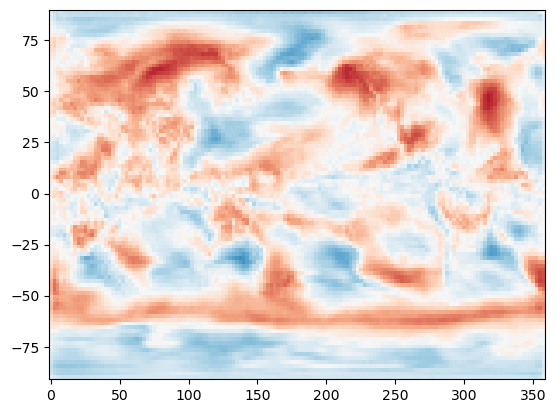

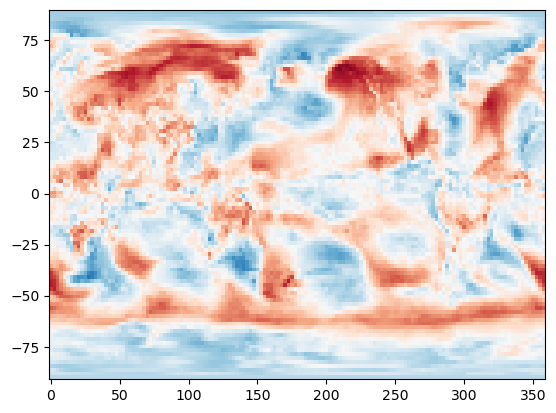

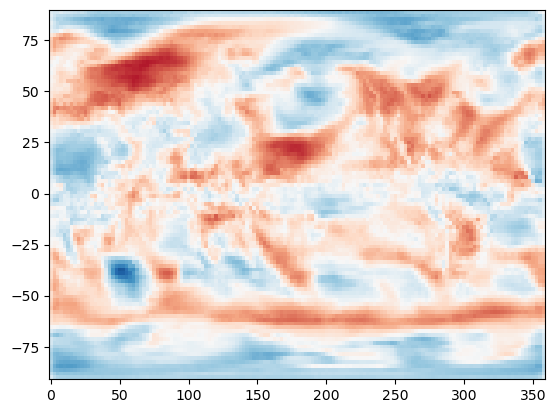

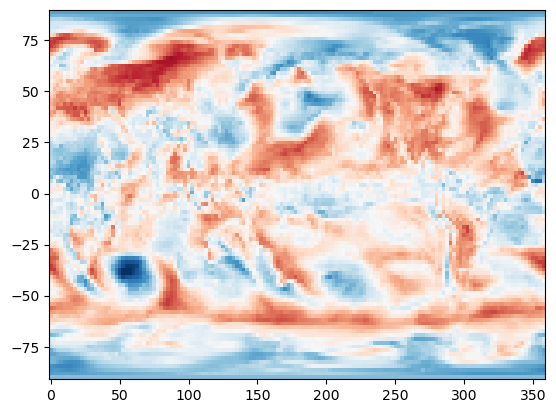

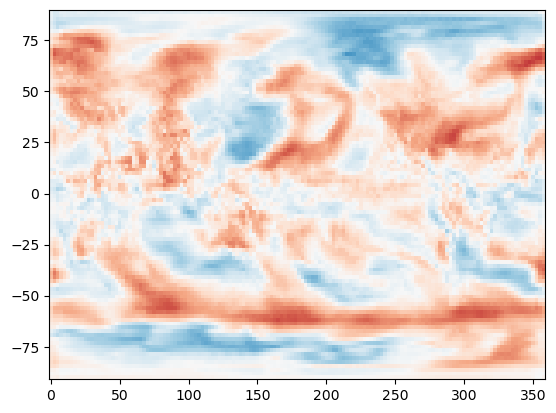

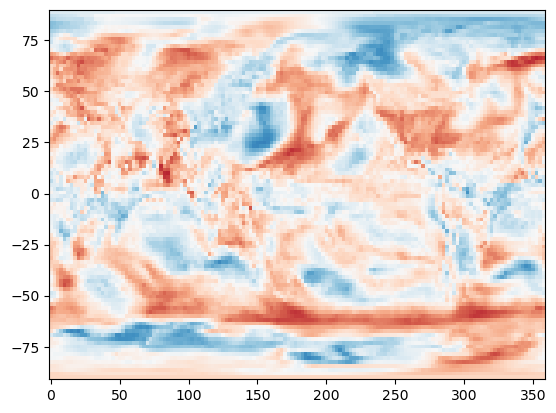

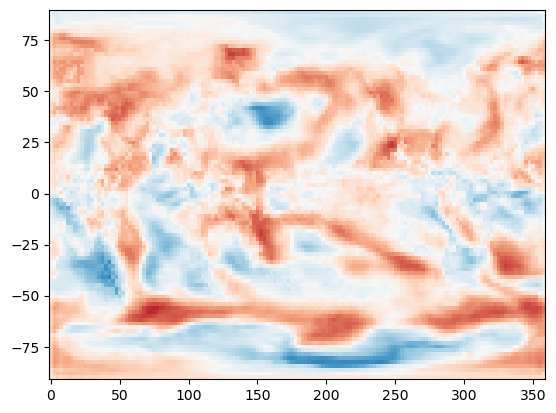

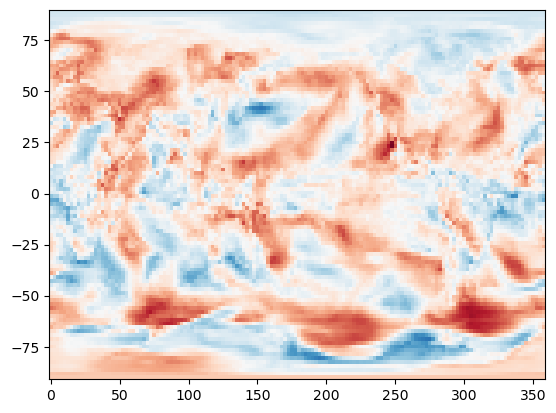

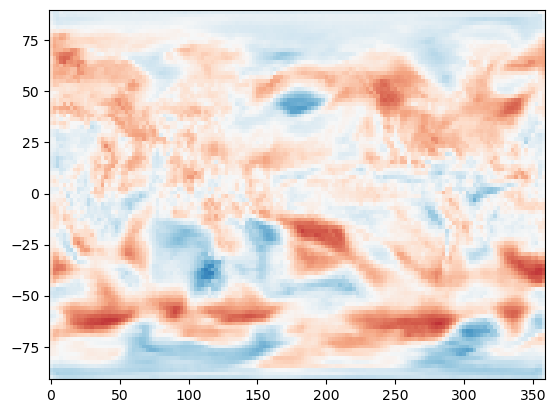

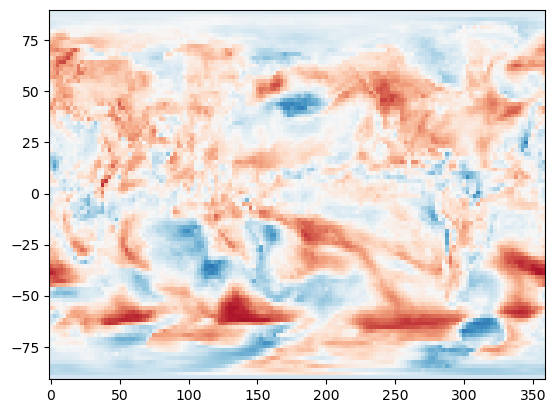

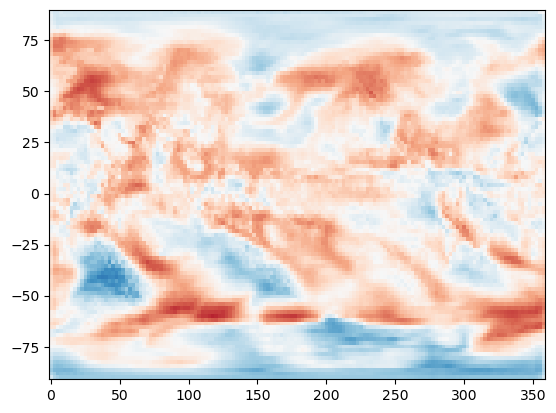

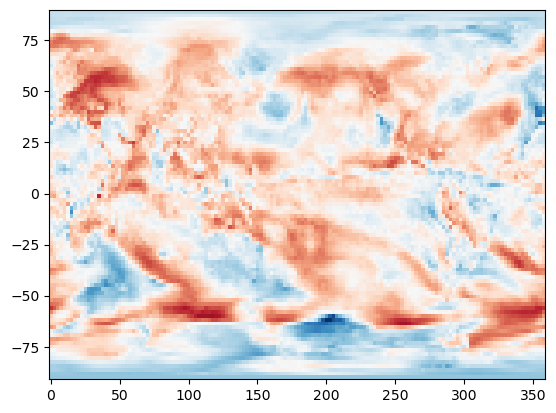

In [34]:
lon = xval.lon
lat = xval.lat

for i in np.arange(0,300,50):
    val_pred_reshape = val_pred[i].squeeze()#.reshape((96,144))
    Yval_reshape = Yval[i].squeeze()#.reshape((96,144))
    
    fig = plt.figure()
    ax = plt.axes()
    ax.pcolormesh(lon,lat,val_pred_reshape,cmap='RdBu_r',vmin=0,vmax=1)
    plt.show()
    fig = plt.figure()
    ax = plt.axes()
    ax.pcolormesh(lon,lat,Yval_reshape,cmap='RdBu_r',vmin=0,vmax=1)
    plt.show()